In [1]:
#Importing the necessary packages
import numpy as np
import cv2
import os

#Setting up proper resource paths
image_path=input('Path of valid input image=:\nHint:images/image_name.jpg\n')
proto_path= "MobileNetSSD_deploy.prototxt.txt"
model_path= "MobileNetSSD_deploy.caffemodel"
confidence_m= 0

#creating a variable to store the number of objects detected
num_of_objects = 0

#creating a list to store the detected objects
objects_list = []

# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(proto_path,model_path)

# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
# (note: normalization is done via the authors of the MobileNet SSD
# implementation)

image = cv2.imread(image_path)
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

# pass the blob through the network and obtain the detections and
# predictions
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in np.arange(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the
    # prediction
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence
    if confidence > confidence_m:
        # extract the index of the class label from the `detections`,
        # then compute the (x, y)-coordinates of the bounding box for
        # the object
        idx = int(detections[0, 0, i, 1])
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        #Counting the number of objects detected
        num_of_objects = num_of_objects + 1
        
        #Appending the objects discovered into the list containing the objects
        objects_list.append(CLASSES[idx])
        # display the prediction
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[INFO] {}".format(label))
        cv2.rectangle(image, (startX, startY), (endX, endY),
            COLORS[idx], 2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(image, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

Path of valid input image=:
Hint:images/image_name.jpg
images/example_06.jpg
[INFO] loading model...
[INFO] computing object detections...
[INFO] chair: 48.39%
[INFO] dog: 83.09%
[INFO] person: 99.99%


Note:Run again if image does not appear


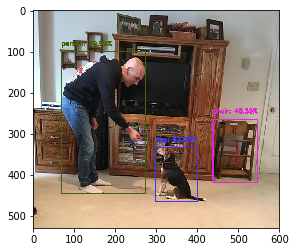

In [3]:
# show the output image
print("Note:Run again if image does not appear")
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

In [7]:
print("Number of objects detected by the MobileNet SSD are:",num_of_objects)
response = input("Do you want to do a deeper search using YOLO algorithm? Type Yes or No:\n")

Number of objects detected by the MobileNet SSD are: 3
Do you want to do a deeper search using YOLO algorithm? Type Yes or No:
yes


Running Script.....

Number of objects detected using YOLO algorithm are: 4

The names of the objects detected are:
 ['tvmonitor', 'person', 'dog', 'chair']


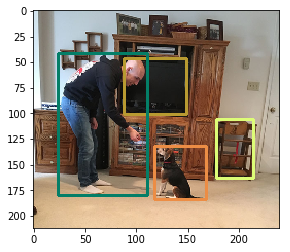

In [8]:
if response.lower() == "yes":
    print("Running Script.....\n")
    # Load Yolo
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    classes = []
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # Loading image
    img = cv2.imread(image_path)
    img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    
    #creating a variable to store the number of objects detected using YOLO
    num_of_objects_yolo = 0
    
    #creating a list to store the names of the objects detected using YOLO algorithm
    yolo_object_list = []
    
    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    # Showing informations on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            num_of_objects_yolo = num_of_objects_yolo + 1
            yolo_object_list.append(label)
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            
    print("Number of objects detected using YOLO algorithm are:",num_of_objects_yolo)
    print("\nThe names of the objects detected are:\n",yolo_object_list)
    
    #
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()
else:
    print("Thank You")
